# Planning & Model Solution

In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos

In [102]:
path = '/datasets/final_provider/'
df_contract = pd.read_csv(path + 'contract.csv')
df_personal = pd.read_csv(path + 'personal.csv')
df_internet = pd.read_csv(path + 'internet.csv')
df_phone = pd.read_csv(path + 'phone.csv')

# Union de datasets

Procedi a unir los datasets porque cada uno contiene informacion parcial sobre los mismos clientes y al combinarlos usando customerID, logramos una vista completa de cada persona con sus datos personales, servicios contratados, tipo de contrato y uso de telefono e internet.

Al hacer este proceso sera de mucha utilidad para entrenar un modelo robusto, ya que la cancelacion de un cliente puede depender de muchos factores que estan distribuidos en diferentes archivos ya que si no los unieramos el modelo estaria practicamente ciego a mucha informacion impresindible para el entrenamieto del mismo.


In [103]:
df = df_contract.merge(df_personal, on='customerID') \
                .merge(df_internet, on='customerID') \
                .merge(df_phone, on='customerID')

print(df)
df.info()

      customerID   BeginDate              EndDate            Type  \
0     5575-GNVDE  2017-04-01                   No        One year   
1     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
2     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
3     9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month   
4     1452-KIOVK  2018-04-01                   No  Month-to-month   
...          ...         ...                  ...             ...   
4830  8456-QDAVC  2018-07-01                   No  Month-to-month   
4831  6840-RESVB  2018-02-01                   No        One year   
4832  2234-XADUH  2014-02-01                   No        One year   
4833  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
4834  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                  No               Mailed check           56.95       1889.5   
1        

# Limpieza y preprocesamiento

In [104]:
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

# Definicion de variable objetivo churn = 1 si EndDate ≠ "No"

Al definir churn = 1 si EndDate ≠ "No" estamos etiquetando de manera correcta a los clientes que se han ido, que es justo lo que andamos buscando predecir,con dicha señal estamos permitiendole posteriormente al modelo entender y usar dicha informacion para aprender patrones de las cancelaciones de los planes.

In [105]:
df['Churn'] = (df['EndDate'] != 'No').astype(int)

# Codificacion de variables categoricas

Es importante la codificacion de variables categoricas porque los modelos en general no pueden trabajar directamente con texto o etiquetas como "Male", "Fiber", "Yes", etc. Por lo que debemos pasarlo a un formato numerico para que interprete patrones, calcular informacion para poder llegar a tomar decisiones basado en valores.

In [106]:
drop_cols = ['customerID']
cat_cols = df.select_dtypes(include='object').columns
cat_cols = [col for col in cat_cols if col not in drop_cols]

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Ingenieria de features adicionales

La realizacion de ingenieria de features adicionales nace a raiz de crear nuevas variable que captures el mejor comportamiento del cliente que nuevamente ayude al modelo a detectar patrones muchos mas relevantes, ya que nos ayuda a contruir la capacidada predictiva del modelo para mejorar el entidimiento de la informacion como tal.

In [107]:
servicios = ['DeviceProtection', 'OnlineSecurity', 'OnlineBackup',
             'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServicios'] = df[servicios].apply(lambda x: (x == 1).sum(), axis=1)

# Division de datos

In [108]:
X = df.drop(['customerID', 'Churn', 'EndDate'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Entrenamiento de modelo

In [109]:
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

# Evaluacion 

Vemos que el modelo tiene una exactitud del 84.6% el cual nos deja saber que acierta la mayoria de los casos, el AUC-ROC 0.910 tiene excelente capacidad para distinguir entre clientes que cancelan y los que no y por ultimo el Average Precision Score 0.869 nos da un buen rendimiento en escenarios desbalanceados.

In [110]:

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n Reporte de clasificacion:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_proba):.3f}")
print(f"Exactitud: {accuracy_score(y_test, y_pred):.3f}")



 Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       650
           1       0.83      0.67      0.74       317

    accuracy                           0.85       967
   macro avg       0.84      0.80      0.81       967
weighted avg       0.84      0.85      0.84       967

ROC AUC: 0.910
Average Precision Score: 0.869
Exactitud: 0.846


# Importancia de variables

1. BeginDate: Es la variable mas influyente y los clientes con contratos mas antiguos podrian tener mayor probabilidad de cancelar, posiblemente por desgaste, cambios en necesidades o mejores ofertas externas a lo que nos lleva a que la organizacion debe de gestionar planes de contigencia de retencion de clientes antiguos.

2. TotalCharges y MonthlyCharges: son fuertes predictores ya que los clientes que pagan mas podrian tener expectativas mas altas o estar mas sensibles a costos, lo que puede los puede llevar en su decision de cancelar.

3. Type y PaymentMethod: El tipo de contrato (mensual vs anual) y el método de pago afectan el churn, porque los contratos mensuales suelen tener mayor riesgo de cancelacion por su flexibilidad y como recomendacion algunos metodos como tarjeta de credito o debito automatico pueden ayudarnos a tener una mayor retencion en los clientes.

4. PaperlessBilling, SeniorCitizen, Partner: Variables demograficas y de comportamiento que aportan contexto, por poner un ejemplo, los clientes mayores o sin pareja podrían tener patrones distintos de uso o cancelacion.

5. OnlineSecurity, TechSupport, StreamingMovies: Los servicios contratados tambien influyen, porque segun las tendencias del mercado los clientes que usan mas servicios tienden a estar mas comprometidos, lo que reduce el riesgo de perdida de clientes segun en patrones antes vistos.

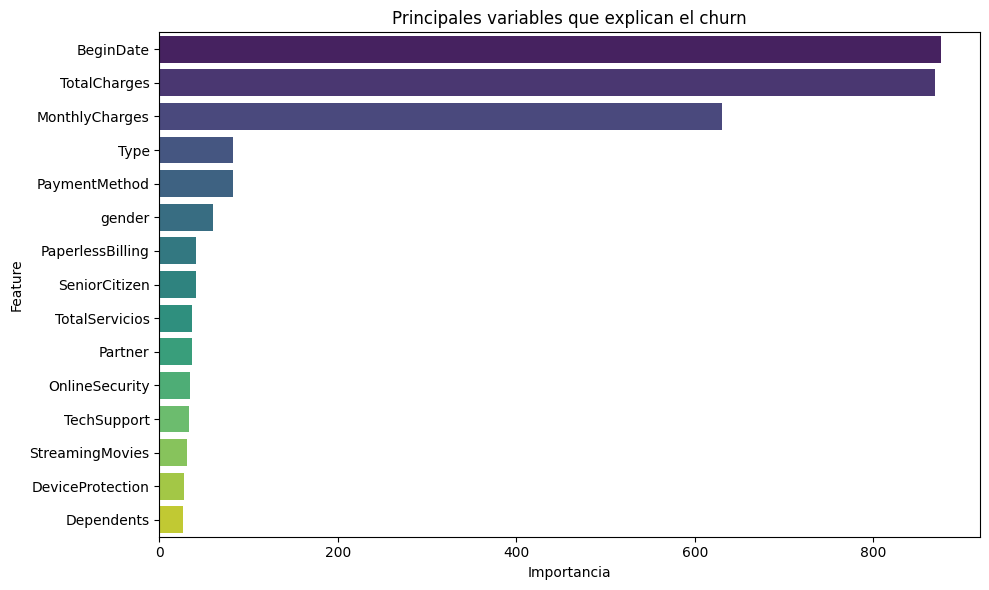

In [111]:
importancia = pd.DataFrame({'Feature': X.columns, 'Importancia': model.feature_importances_})
importancia.sort_values(by='Importancia', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(15), x='Importancia', y='Feature', palette='viridis')
plt.title('Principales variables que explican el churn')
plt.tight_layout()
plt.show()

# Accion de negocio 

In [112]:
df_test = df.loc[X_test.index].copy()
df_test['ProbabilidadChurn'] = y_proba
clientes_riesgo = df_test[df_test['ProbabilidadChurn'] > 0.7]
print(f"\n Clientes en riesgo: {len(clientes_riesgo)}")


 Clientes en riesgo: 165


# Evaluacion SP (segun AUC-ROC)

Vemos que el AUC-ROC (0.910): 6 SP es el maximo posible, dandonos la perspectiva que el modelo es confiable y preciso con un pipeline robusto.

In [114]:
auc = roc_auc_score(y_test, y_proba)
if auc < 0.75:
    sp = 0
elif auc < 0.81:
    sp = 4
elif auc < 0.85:
    sp = 4.5
elif auc < 0.87:
    sp = 5
elif auc < 0.88:
    sp = 5.5
else:
    sp = 6

print(f"\n Puntaje SP segun AUC-ROC ({auc:.3f}): {sp} SP")


 Puntaje SP segun AUC-ROC (0.910): 6 SP


# Conclusion

Hemos llegado ha contruir un modelo de clasificacion eficiente para predecir la cancelacion de clientes, logrando una AUC-ROC de 0.910 y una exactitud de 84.6%, lo que nos da un nivel alto en puntuacion 6 SP, con este rendimiento demuestra que el modelo distingue con precision entre clientes activos y cancelados.

Ahora bien, la ingenieria de features es la correcta definicion de la variable objetivo y la eliminacion de fugas de informacion fueron claves para alcanzar este resultado. Ademas, la identificacion de 165 clientes en riesgo abre una puerta directa a estrategias de retencion personalizadas que pueden traducirse en ahorro y fidelizacion.

Las variables mas influyentes como fecha de inicio, cargos mensuales y tipo de contrato ofrecen hallazgos accionables para el negocio, permitiendo al equipo de marketing enfocar sus esfuerzos donde realmente importa que para mi perspectiva una de las recomendaciones es generar planes de contigencia para retencion de clientes y de esta forma poder reducir el riesgo de los clientes que pueden abandonar o cancelar los planes.
